## <center> Итоговый проект первого года обучения ##
### <center> Агентство недвижимости ###

**Цель:** Разработать сервис для предсказания стоимости домов на основе истории предложений


In [1]:
import pandas as pd
import numpy as np
import json
import ast
from statistics import mean, median
from sklearn.model_selection import train_test_split

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import sys, os
sys.path.append(os.path.join(os.path.abspath(''), '..', 'libs'))
import preparation

import importlib, sys
importlib.reload(sys.modules['preparation'])
from preparation import parsing_homeFacts, parsing_schools, parsing_year_build

Созданим справочник констант. В него будут записываться постоянные значения (моды, медианы, средние значения), которые будут получены на моменте подготовки и очистки модели и которые будут использоваться в сервисе для предсказания значений целевой метрики 'target'

Структура const_dict:
* ключ: имя параметра
* значение: константа (моды, медианы, средние значения) 

In [2]:
const_dict = dict()

In [3]:
df = pd.read_csv('data/data.csv')

In [4]:
df.head(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"


In [5]:
df.isna().sum()

status           39918
private pool    373004
propertyType     34733
street               2
baths           106338
homeFacts            0
fireplace       274070
city                34
schools              0
sqft             40577
zipcode              0
beds             91282
state                0
stories         150715
mls-id          352243
PrivatePool     336874
MlsId            66880
target            2481
dtype: int64

In [6]:
df.shape

(377185, 18)

Удалим строки с нулевой ценой, а так же где нет значений в колонке 'city'

In [7]:
df = df[~df['target'].isna()]
df = df[~df['city'].isna()]

In [8]:
df['target']

0           $418,000
1           $310,000
2         $2,895,000
3         $2,395,000
4             $5,000
             ...    
377180    $1,249,000
377181      $674,999
377182      $528,000
377183       $34,500
377184      $204,900
Name: target, Length: 374670, dtype: object

Значения в колонке 'target' представляют собой строку с набором символов, цифр. Попробуем определить из каких символов состоят эти значения

In [9]:
symbols_set = set()
def get_symbols_str(text):
    for item in text:
        symbols_set.add(item)

df['target'].apply(get_symbols_str)
symbols_set    

{' ',
 '$',
 '+',
 ',',
 '-',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'm',
 'o'}

В отличие от знака $ и цифр встречаются символы '+', '-', '/', 'm', 'o'. В дальнейшем перебирая строки, где встречаются данные символы, установил, что связка символов '-' и '/mo' встречается в строках, где значение в колонке статус равен 'for rent'

In [10]:
mask = df['target'].str.contains('-')
display(df[mask])
# удалим данную строку
df = df[~mask] 

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
330468,for rent,NaN,apartment,The Collette Apartments in Dallas,1-2 Baths,"{'atAGlanceFacts': [{'factValue': '1964', 'fac...",NaN,Dallas,"[{'rating': ['5/10', '5/10', '5/10'], 'data': ...",610-840 sqft,75206,1-2 Beds,TX,NaN,NaN,NaN,NaN,"$1,215 - $1,437/mo"


Проанализируем значения, где встречается цена аренды с подстрокой '/mo

count      397.000000
mean      3229.556641
std       4929.681152
min        600.000000
25%       1500.000000
50%       2150.000000
75%       3300.000000
max      72500.000000
Name: target, dtype: float64

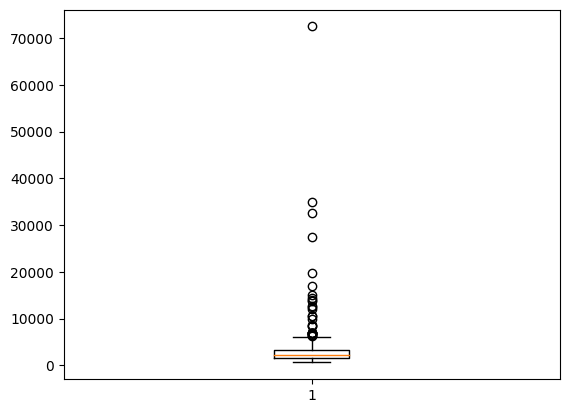

In [11]:
mask = df['target'].str.contains('/mo')
df_rent = df[mask].copy()
pattern = r'(\d*\.\d+|\d+)'

df_rent['target'] = df_rent['target'].str.replace(',','')
df_rent["target"] = pd.to_numeric(df_rent["target"].str.extract(pattern)[0], downcast='float')

display(df_rent['target'].describe())

plt.boxplot(df_rent['target'])
plt.show()


В основном диапазон аренды лежит до 35000. Примем данный факт к тому , что мы будем рассматривать продажи от 35000. 

Проанализируем сколько у нас записей  с ценой до 35000 в основном датасете

Преобразуем значения в колонке 'target'. 

In [12]:
pattern = r'(\d*\.\d+|\d+)'

df['target'] = df['target'].str.replace(',','')
df["target"] = pd.to_numeric(df["target"].str.extract(pattern)[0], downcast='float')


In [13]:
display(df['target'].describe())
print('Число записей с ценой продажи меньше 35000 составляет: {}'.format(df[df['target']<35000].shape[0]))

count    3.746690e+05
mean     6.447391e+05
std      1.841411e+06
min      1.000000e+00
25%      1.869900e+05
50%      3.200000e+05
75%      5.820000e+05
max      1.950000e+08
Name: target, dtype: float64

Число записей с ценой продажи меньше 35000 составляет: 17744


Минамальная и максимальная цена составляют 1 и 195000000 соотвественно. Рассмотрим распределение цены. Построим графики цены.

<AxesSubplot:>

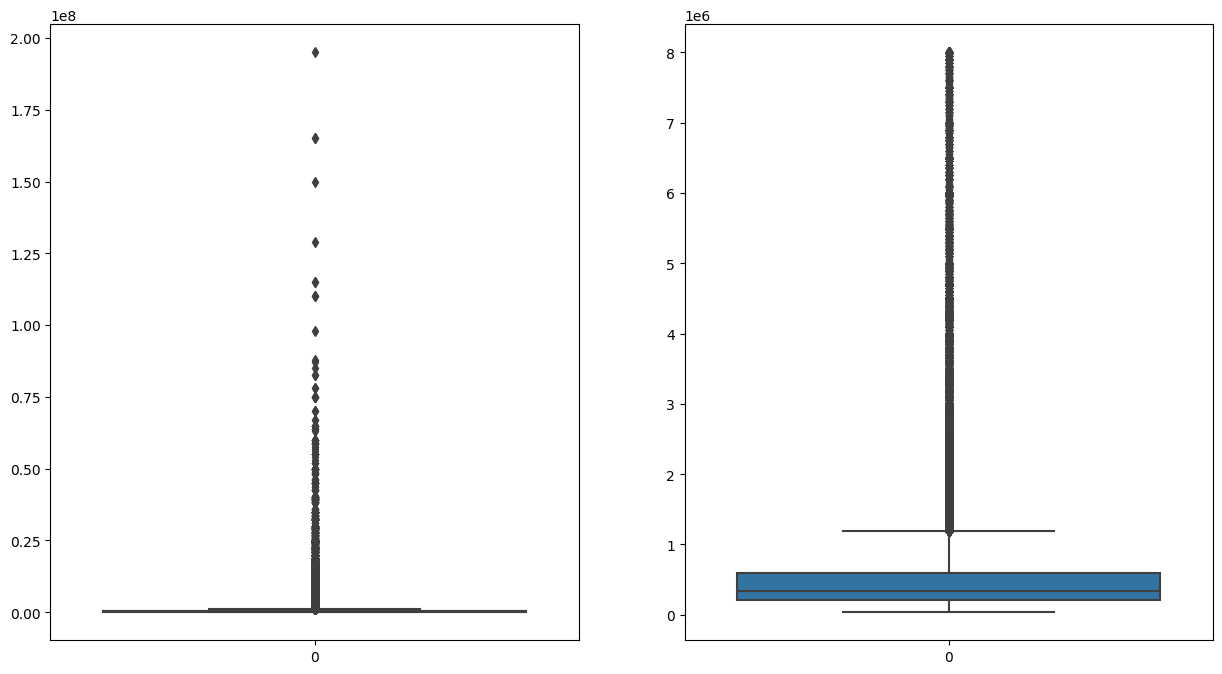

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

sns.boxplot(
    data=df['target'],    
    ax=ax[0]
)

mask = (df['target']>35000)&(df['target']<8000000)
sns.boxplot(
    data=df[mask]['target'],    
    ax=ax[1]
)

Первый график показывает распределение цены со всеми выбросами как вверхней так и нижней частях диапазона цены. Второй график учел аренду (от 35000), а так же выбросы цены свыше 8000000


In [15]:
mask = (df['target']>35000)&(df['target']<8000000)

df = df[mask]
df.shape

(353746, 18)

Разобьем наш датасет на основной и валидационный. Основной датасет будет необходим для поиска и обучения модели предсказания целевой метрики 'target', а валидационный датасет нам понадобиться на моменте проверки сервиса предсказания.

In [16]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.005, random_state=42)

Сохраним валидационный датасет в файлы формата csv

In [17]:
X_valid.to_csv('data/df_X_valid.csv', index=False)
y_valid.to_csv('data/df_y_valid.csv', index=False)

In [18]:
df11 = pd.concat([X_train, y_train], axis=1)
df11.to_csv('data/df11.csv', index=False)


In [19]:
df = pd.concat([X_train, y_train], axis=1)
df.shape

(351977, 18)

In [20]:
df['status'].value_counts()

for sale                146929
Active                   96300
For sale                 42322
New construction          5403
foreclosure               4495
                         ...  
Coming soon: Oct 21.         1
Coming soon: Dec 1.          1
Coming soon: Dec 12.         1
Coming soon: Nov 17.         1
Coming soon: Nov 14.         1
Name: status, Length: 154, dtype: int64

Больше 80% составляют объявления со статусами 'for sale', 'Active', 'For sale' (статус продажа). Поэтому рассматриваем, что у нас все записи, только продажа. Удалим колонку 'status'

In [21]:
df = df.drop(['status'], axis=1)

In [22]:
print('column = "private pool"')
print(df['private pool'].value_counts())
print('=======================')
print('column = "PrivetePool"')
print(df['PrivatePool'].value_counts())
df[df['private pool']=='Yes'].head(2)

column = "private pool"
Yes    4061
Name: private pool, dtype: int64
column = "PrivetePool"
yes    27770
Yes    11020
Name: PrivatePool, dtype: int64


,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
334830,Yes,Condo,4816 Amesbury Dr APT 227,Bathrooms: 2,"{'atAGlanceFacts': [{'factValue': '1963', 'fac...",NaN,Dallas,"[{'rating': ['9/10', '5/10', '5/10'], 'data': ...","Total interior livable area: 1,290 sqft",75206,2 bd,TX,1.0,14229122,NaN,NaN,242000.0
60617,Yes,Single Family,13350 Twin Lake Ave,Bathrooms: 2,"{'atAGlanceFacts': [{'factValue': '1985', 'fac...",Yes,Spring Hill,"[{'rating': ['5/10', '6/10', '5/10'], 'data': ...","Total interior livable area: 1,700 sqft",34609,3 bd,FL,1.0,U8060188,NaN,NaN,196500.0


В колонке "private pool" присутствуют значения только одного вида "Yes", а в колонке "PrivatePool" присутствуют значения вида "yes" и "Yes". Так же существуют строки, в которых заполнено значение в колонке "private pool" и не заполнено значение в колонке "PrivatePool". Поэтому заполним пустые значения в колонке "PrivatePool" значениями "private pool", так же заменим Yes, yes на 1, а пустые значения нулями и удалим колонку "private pool"   

In [23]:
df['PrivatePool'] = df['PrivatePool'].fillna(df['private pool'])
df['PrivatePool'] = df['PrivatePool'].apply(lambda x: 1 if x=='Yes' or x=='yes' else 0)

df = df.drop(['private pool'], axis=1)

In [24]:
display(df['propertyType'].value_counts().head(20))
print('Количество уникальных:',len(df['propertyType'].value_counts().to_list()))
print('Количество пустых значений:', df['propertyType'].isna().sum())

single-family home               88232
Single Family                    60627
Single Family Home               31194
condo                            25365
Condo                            16205
lot/land                         14426
townhouse                        11213
Condo/Townhome/Row Home/Co-Op     7623
multi-family                      7498
Townhouse                         6811
Land                              5931
Traditional                       5864
coop                              3181
Multi Family                      2646
High Rise                         1803
Ranch                             1752
Detached, One Story               1603
Single Detached, Traditional      1568
Contemporary                      1547
Multi-Family Home                 1416
Name: propertyType, dtype: int64

Количество уникальных: 1266
Количество пустых значений: 30816


У нас в колонке 'propertyType' 1266 уникальных элемента, но видно, что есть элементы похожие, но по разному написанные. 
Сделаем следующее:
* Всем пустым значениям присвоим значение 'other'
* Переведем все значения в нижний регистр 
* Доставим к каждому значению строку 'other'. Когда будем объединять в группы, заменяя значения, то оставшиеся элементы найдем по вхождени. подстроки 'other'  
* Создадим список групп
* в колонке 'propertyType' заменим все значения на значения из списка групп. 

In [25]:
df['propertyType'] = df['propertyType'].fillna(df['propertyType'].mode()[0])

# === Пишем в словарь констант
const_dict['propertyType'] = df['propertyType'].mode()[0] 
# ===

df['propertyType'] = df['propertyType'].str.lower()
df['propertyType'] = df['propertyType'].apply(lambda x: x+' other')

lst_propertyType = ['single', 'condo', ['land', 'lot'], ['townhouse','townhome'], 'multi', 'traditional', 
                    ['coop', 'co-op'], ['ranch', 'farm'], 'high rise', ['low-rise', 'low'], 'detached', 'mobile', ['contemporary','modern'],
                    ['1 story', '1', 'one story'], ['2 story', '2', '2 stories', 'two stories', 'two story', 'stories'], ['3 stor', '3'], ['colonial', 'transitional', 'historical'],
                    ['garden', 'cluster home'], 
                    ['craft', 'cottage', 'tri-level', 'bungalow', 'cape', 'spanish', 'mediterranean', 'victorian', 'florida', 'french', 'georgian', 'loft', 'art', 'tudor'],
                    ['other', 'custom', 'manufactured']]

mask_nan = df['propertyType'].isna()

for item in lst_propertyType:
    if type(item)==list:
        for ind, prprt in enumerate(item):
            df['propertyType'].where(~(df[~mask_nan].propertyType.str.contains(prprt) ), other=item[0], inplace=True)
    else:
        df['propertyType'].where(~(df[~mask_nan].propertyType.str.contains(item) ), other=item, inplace=True) 
        
 
print('Количество уникальных элементов в колонке "propertyType":', df['propertyType'].nunique())
print(df['propertyType'].unique())


Количество уникальных элементов в колонке "propertyType": 20
['land' 'single' 'townhouse' 'condo' 'contemporary' 'detached' 'coop'
 'traditional' 'ranch' '1 story' '2 story' 'multi' 'craft' 'other'
 'mobile' 'high rise' 'colonial' 'garden' 'low-rise' '3 stor']


Вместо 1266 будет 20 уникальных параметров в колонке 'propertyType'

In [26]:
df['propertyType'].value_counts()

single          214419
condo            50179
land             20384
townhouse        18205
multi            11857
traditional       7478
coop              3731
contemporary      3404
mobile            2990
craft             2870
ranch             2868
detached          2498
1 story           2207
other             2207
high rise         1926
colonial          1817
2 story           1758
low-rise           666
garden             499
3 stor              14
Name: propertyType, dtype: int64

Пустые значения в колонках 'baths' и 'beds' заменим значения медианным значением, предарительно сгруппировав по колонке 'zipcode'. После все пустые значения поставим 0 

Если присутствуют значения в колонке 'fareplace', то ставим 1, в остальных случаях 0

In [27]:
# Преобразуем колонку 'baths' и 'beds'
pattern = r'(\d*\.\d+|\d+)'
df["baths"] = pd.to_numeric(df["baths"].str.extract(pattern)[0], downcast='float')
df["beds"] = pd.to_numeric(df["beds"].str.extract(pattern)[0], downcast='float')

# === Пишем в словарь констант
const_dict['baths_group'] = df.groupby("zipcode")["baths"].transform("median") 
const_dict['beds_group'] = df.groupby("zipcode")["beds"].transform("median")
const_dict['baths'] = df["baths"].median() 
const_dict['beds'] = df["beds"].median()
# ===

df["baths"] = df["baths"].fillna(df.groupby("zipcode")["baths"].transform("median"))
df["baths"] = df["baths"].fillna(0)


df["beds"] = df["beds"].fillna(df.groupby("zipcode")["beds"].transform("median"))
df["beds"] = df["beds"].fillna(0)

df['fireplace'] = df['fireplace'].fillna('0')
df['fireplace'] = df['fireplace'].apply(lambda x: 0 if x.lower() in ['0', 'no', 'not applicable'] else 1)

# Удалим лишнии колонки
df = df.drop(columns=['street', 'stories', 'mls-id', 'MlsId'], axis=1)


Распарсим колонки 'homeFacts' и 'schools' и создадим новые колонки

In [28]:
df = parsing_homeFacts(df)
df = parsing_schools(df)
df.shape

(351977, 23)

In [29]:
print('Количество неопределенных значений {}'.format(df['Year built'].isna().sum()))
print('Количество пустых значений {}'.format(df[df['Year built']=='']['Year built'].count()))
print('Количество No Data {}'.format(df[df['Year built']=='No Data']['Year built'].count()))

Количество неопределенных значений 3074
Количество пустых значений 44976
Количество No Data 1135


В колонках 'Year build' Пустые значения заменим на np.nan. Так же в данных присутствуют значения, отличного от принятого четырехзначного года. Используем паттерн вида (^\d{4}$) и приводим все значения к виду гггг.

In [30]:
df['Year built'] = df['Year built'].replace('',np.nan)
df['Year built'] = df['Year built'].replace('No Data',np.nan)
pattern = r'(^\d{4}$)'
df['Year built'] = df['Year built'].str.extract(pattern)[0]

In [31]:
s_year = pd.to_numeric(df['Year built'])
print('========== Year built =========')
display(s_year.describe())

========== Year built =========


count    302788.000000
mean       1980.011919
std          33.339058
min        1019.000000
25%        1958.000000
50%        1986.000000
75%        2007.000000
max        2025.000000
Name: Year built, dtype: float64

В датасете значения в колонке 'Year build' варьируются в интервале от 1019 до 2025 года.

Пустые значения заполним средним значением

Разобьем года постройки на интервалы с 1850 по 2010 с шагом в 10 лет. и запишим в новую колонку 'interval_year'.

In [32]:
# === Пишем в словарь констант
const_dict['Year built'] = str(int(s_year.quantile()))
# ===

df['Year built'].fillna(str(int(s_year.quantile())), inplace=True) 
# парсим значения в колонке 'Year build' и записываем новые значения в колонку 'intervcal_year'
df = parsing_year_build(df)

Изменения значений в колонке 'Remodeled year':
1. Все пустые значения и 'No Data' меняем на np.nan
2. все np.nan меняем на 0, а остальные на 1 

In [33]:
pattern = r'(^\d{4}$)'
df['Remodeled year'] = df['Remodeled year'].str.extract(pattern)[0]
df['Remodeled year'] = df['Remodeled year'].fillna(0)

df['Remodeled year'] = df['Remodeled year'].apply(lambda x: 0 if x==0 else 1)

In [34]:
display(df['Price/sqft'].value_counts())

                   4386
No Data            1005
No Info             877
$125/sqft           785
$115/sqft           765
                   ... 
$1,763                1
$2,020/sqft           1
$2,833/sqft           1
$2,213/sqft           1
$1931 / Sq. Ft.       1
Name: Price/sqft, Length: 5654, dtype: int64

преобразуем все значения в колонках "Price/sqft" и "sqft" следующим образом:
1. Заменим "," на ""
2. Получим только цифры
3. Заполним все пустые значения медианой, предварительно сгруппировав по 'zipcode'
4. Оставшиеся пустые значения заполним медианой

In [35]:

df['price/sqft'] = df['Price/sqft'].str.replace(',','')
pattern = r'\b(\d+)\b'
df['price/sqft'] = pd.to_numeric(df['price/sqft'].str.extract(pattern)[0])

df['sqft'] = df['sqft'].str.replace(',','')
df['sqft'] = pd.to_numeric(df['sqft'].str.extract(pattern)[0])

const_dict['price/sqft_group'] = df.groupby("zipcode")["price/sqft"].transform("median")
df["price/sqft"] = df["price/sqft"].fillna(df.groupby("zipcode")["price/sqft"].transform("median"))

const_dict['sqft_group'] = df.groupby("zipcode")["sqft"].transform("median")
df["sqft"] = df["sqft"].fillna(df.groupby("zipcode")["sqft"].transform("median"))

const_dict['price/sqft'] = df["price/sqft"].median()
df["price/sqft"] = df["price/sqft"].fillna(df["price/sqft"].median())

const_dict['sqft'] = df["sqft"].median()
df["sqft"] = df["sqft"].fillna(df["sqft"].median())


count    3.519770e+05
mean     4.139980e+03
std      7.700724e+05
min      0.000000e+00
25%      1.300000e+03
50%      1.820000e+03
75%      2.551000e+03
max      4.566025e+08
Name: sqft, dtype: float64

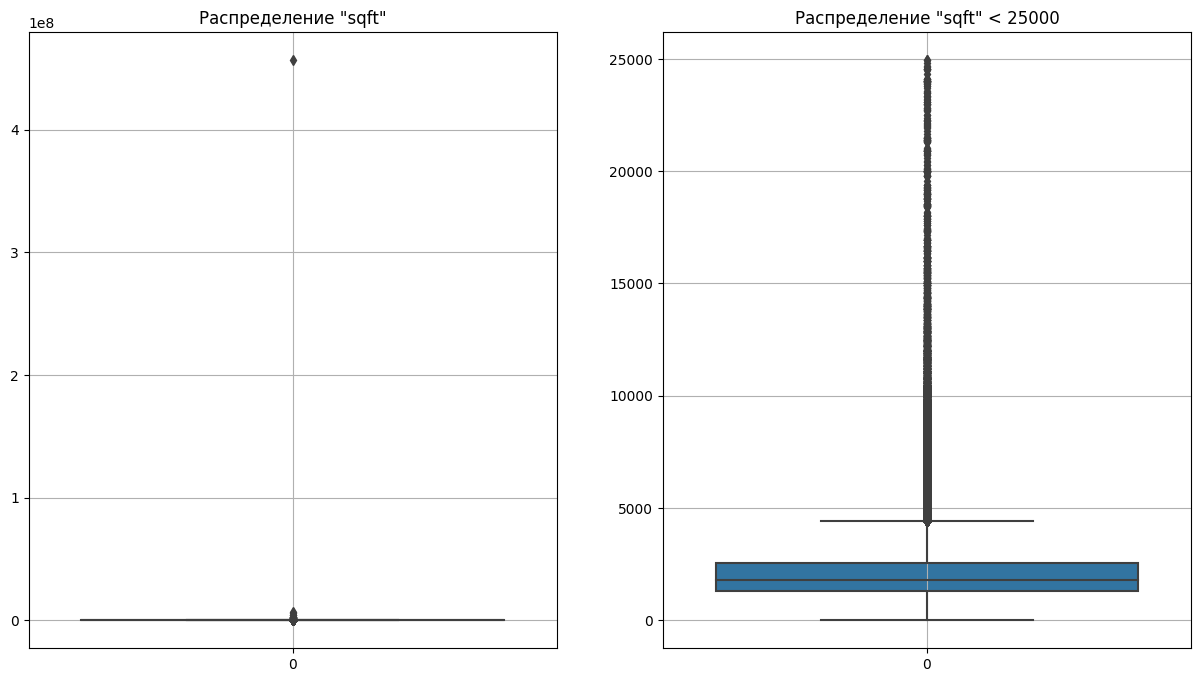

In [36]:
display(df['sqft'].describe())

fig, ax = plt.subplots(1, 2, figsize=(15, 8))

sns.boxplot(
    data=df['sqft'],    
    ax=ax[0]
)
ax[0].set_title('Распределение "sqft"')
ax[0].grid()

mask = df['sqft']<25000
sns.boxplot(
    data=df[mask]['sqft'],    
    ax=ax[1]
)
ax[1].set_title('Распределение "sqft" < 25000')
ax[1].grid()

Значения параметра 'sqft' лежат в диапазоне от 0 до 457000000. 

На графике слева показано распределение парамметра 'sqft' основного датасета. На графике справа показано распределение параметра 'sqft', где значения не превышают 25000. 
Исследования показали, что 99% записей лежит в диапазоне от 0 до 25000

In [37]:
mask25000 = df['sqft']<25000
print('Процент записей в датасете, значения параметра "sqft" не превышают 25000: {:.2f}%'.format(df[mask25000].shape[0]/df.shape[0]*100))

Процент записей в датасете, значения параметра "sqft" не превышают 25000: 99.61%


In [38]:
# Удалим записи, где значения параметра 'sqft' превышают 25000
df = df[mask25000]

count    3.505990e+05
mean     4.483012e+02
std      2.156328e+04
min      0.000000e+00
25%      1.250000e+02
50%      1.770000e+02
75%      2.990000e+02
max      5.950000e+06
Name: price/sqft, dtype: float64

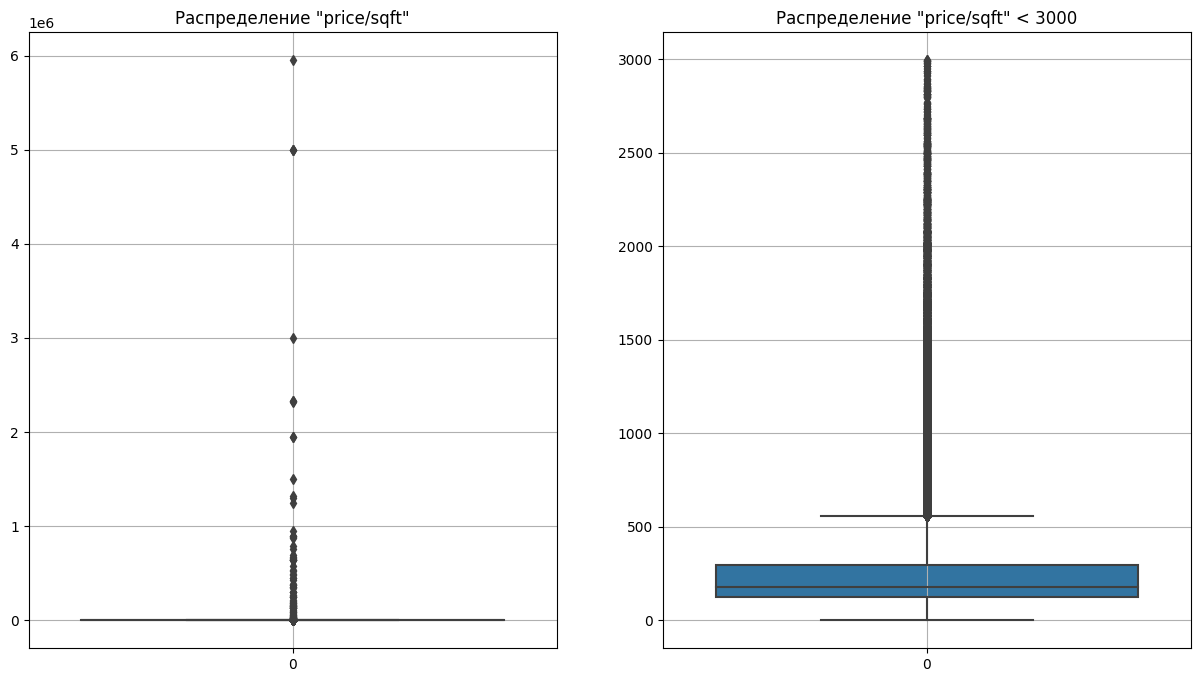

In [39]:
display(df['price/sqft'].describe())

fig, ax = plt.subplots(1, 2, figsize=(15, 8))

sns.boxplot(
    data=df['price/sqft'],    
    ax=ax[0]
)
ax[0].set_title('Распределение "price/sqft"')
ax[0].grid()

mask = df['price/sqft']<3000
sns.boxplot(
    data=df[mask]['price/sqft'],    
    ax=ax[1]
)
ax[1].set_title('Распределение "price/sqft" < 3000')
ax[1].grid()

Значения параметра 'price/sqft' лежат в диапазоне от 0 до 5950000. 

На графике слева показано распределение парамметра 'price/sqft' основного датасета. На графике справа показано распределение параметра 'price/sqft', где значения не превышают 3000. 
Исследования показали, что 99% записей лежит в диапазоне от 0 до 3000

In [40]:
mask3000 = df['price/sqft']<3000
print('Процент записей в датасете, значения параметра "price/sqft" не превышают 25000: {:.2f}%'.format(df[mask3000].shape[0]/df.shape[0]*100))

Процент записей в датасете, значения параметра "price/sqft" не превышают 25000: 99.93%


In [41]:
# Удалим записи, где значения параметра 'price/sqft' превышают 3000
df = df[mask3000]

In [42]:
# Удалим лишнии колонки
df = df.drop(columns=['lotsize', 'Price/sqft'], axis=1)

In [43]:
df['Cooling'].value_counts()

Central                                        154610
                                               100534
Central Air                                     14275
No Data                                         10093
Has Cooling                                      9577
                                                ...  
Heat Pump, Other Cooling                            1
Gas (Hot Air), Propane, Other (See Remarks)         1
Other, Wall, Refrigeration                          1
Electric Heating, Individual Heating                1
1 Unit, Baseboard - Hotwater, Multi-Zone            1
Name: Cooling, Length: 1431, dtype: int64

Значения в колонках "Cooling", "Heating", "Parking" заменим: 0 если "No Data", '', 'None' и 1 во всех остальных случаях


In [44]:
df['Cooling'] = df['Cooling'].fillna('0') 
df['Cooling'] = df['Cooling'].apply(lambda x: 0 if x.lower() in ['','no data', 'none'] else 1)

df['Heating'] = df['Heating'].fillna('0') 
df['Heating'] = df['Heating'].apply(lambda x: 0 if x.lower() in ['','no data', 'none'] else 1)

df['Parking'] = df['Parking'].fillna('0')
df['Parking'] = df['Parking'].apply(lambda x: 0 if x.lower() in ['','no data', 'none'] else 1)

In [45]:
print('======= Cooling =======')
display(df['Cooling'].value_counts())

print('======= Heating =======')
display(df['Heating'].value_counts())

print('======= Parking =======')
display(df['Parking'].value_counts())

======= Cooling =======


1    232883
0    117470
Name: Cooling, dtype: int64

======= Heating =======


1    252356
0     97997
Name: Heating, dtype: int64

======= Parking =======


1    183293
0    167060
Name: Parking, dtype: int64

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350353 entries, 360897 to 129936
Data columns (total 22 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   propertyType    350353 non-null  object 
 1   baths           350353 non-null  float32
 2   fireplace       350353 non-null  int64  
 3   city            350353 non-null  object 
 4   sqft            350353 non-null  float64
 5   zipcode         350353 non-null  object 
 6   beds            350353 non-null  float32
 7   state           350353 non-null  object 
 8   PrivatePool     350353 non-null  int64  
 9   target          350353 non-null  float32
 10  Remodeled year  350353 non-null  int64  
 11  Parking         350353 non-null  int64  
 12  Heating         350353 non-null  int64  
 13  Cooling         350353 non-null  int64  
 14  Elementary      350353 non-null  float64
 15  Middle          350353 non-null  float64
 16  High            350353 non-null  float64
 17  Other

In [47]:
df.isna().sum()

propertyType      0
baths             0
fireplace         0
city              0
sqft              0
zipcode           0
beds              0
state             0
PrivatePool       0
target            0
Remodeled year    0
Parking           0
Heating           0
Cooling           0
Elementary        0
Middle            0
High              0
Other             0
Rating            0
Distance          0
interval_year     0
price/sqft        0
dtype: int64

Данные очищены. Запишим их в отдельный файл

In [48]:
# Производим сериализацию и записываем dataframe в файл формата pkl
with open('data/df_clean.pkl', 'wb') as output:
    pickle.dump(df, output)

In [49]:
# Производим сериализацию и записываем справочник констант в файл формата pkl в папку 'libs'
with open('../libs/data/const_dict.pkl', 'wb') as output:
    pickle.dump(const_dict, output)

В дальнейшем, на очищенных данных, мы проведем подбор модели для предсказания целевой метрики и обучим ее.  